# Klong beam simulation: GlueX detector hits, take 5 (empty target, variable plug)
In previous studies of the Klong beam simulation, the focus was on the flux of particles of different kinds at the entry to the GlueX detector. Initial results showed that the principal background components are

1. soft gammas with 1-10 MeV energy, half inside the beam pipe and the other half spread out over an area including the innermost rings of the CDC;
2. low-energy neutrons with a peak energy around 1 MeV, with exponentially dropping flux all the way up to ~1 GeV;
3. high-energy muons spread out in two broad lobes peaking 100 cm above and below the beam centerline, as a result of the sweeping magnet

One of the big unanswered questions that came up during the KLF Readiness Review in August, 2024 was what impact these backgrounds will have on our ability to trigger on the desired klong reactions in the presence of the background, and how the reconstruction of these reactions will be impacted by extra hits in the detector coming from background particles.

This is a fifth simulation of the KLF beam in Hall D, with the same statistics as the first. The main change from take 4 is that the phi(1020)->KL,KS process that I introduced to the GlueX hdgeant4 physics lists had its exaggeration factor put back to 1000. The other change was to change the thickness (length) of the tungsten plug following the beryllium klong conversion target. There are 10000 output files KLFbeam5_<n>.hddm and bgprofiles5_<n>.hddm, where <n>=1..10000, containing 500k simulated beam photons each. For every one of these 10000 runs, a slightly different thickness was assigned to the tungsten plug, $$\Delta z = 10 + (n-1)/1000\;cm$$ quasi-continuously spanning the range from 10cm to 20cm. Everything else about the simulation is unchanged from take 4.

In [1]:
import ROOT
#%jsroot on
import os
os.chdir("/srv/jupyter/hdgeant4 studies")
#%pip install --user "gluex.hddm_s>=2.2.1"
from gluex import hddm_s
from gluex import xrootd_client as xclient
import numpy as np
#%pip install --user "gluex.jupyroot>=1.0.1"
from gluex.jupyroot.hddmview import hddmview

In [2]:
import dask.distributed
import dask
dclient = dask.distributed.Client(n_workers=50, threads_per_worker=1, dashboard_address='0.0.0.0:8790')

/srv/.local/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8790 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34429 instead
  warnings.warn(


In [3]:
xrdurl = "root://cn445.storrs.hpc.uconn.edu"
xrdpath = "/Gluex/resilient/simulation/KLFbeam-8-2024/"
infile = xrdurl + xrdpath + "KLFbeam5_{0}.hddm"

In [4]:
infiles = [infile.format(i+1) for i in range(10000)]
hview = hddmview(infiles, hddm_s, "Klong_hits5.root")
hview.enable_dask_cluster(dclient)

## Hit multiplicities and pulse height spectra in the GlueX detectors

In [5]:
def start_hits_hinit():
    h = {}
    h['hsc'] = ROOT.TH1D("hsc", "start counter hits", 40, 0, 40)
    h['hsc'].GetXaxis().SetTitle("start counter")
    h['hsc'].GetYaxis().SetTitle("counts")
    h['hscrun'] = ROOT.TH1D("hscrun", "start counter hits vs run", 1000, 120000, 130000)
    h['hscrun'].GetXaxis().SetTitle("run number")
    h['hscrun'].GetYaxis().SetTitle("start counter hits")
    h['hdEsc'] = ROOT.TH1D("hdEsc", "start counter pulse height", 1000, 0, 10)
    h['hdEsc'].GetXaxis().SetTitle("dE (MeV)")
    h['hdEsc'].GetYaxis().SetTitle("counts")
    h['htsc'] = ROOT.TH1D("htsc", "start counter pulse time", 1000, 0, 100)
    h['htsc'].GetXaxis().SetTitle("pulse time (ns)")
    h['htsc'].GetYaxis().SetTitle("counts")
    hclones = {}
    for hname in h:
        hname2 = hname + "_dEmin"
        hclones[hname2] = h[hname].Clone(hname2)
        hclones[hname2].SetLineColor(ROOT.kOrange + 7)
    h.update(hclones)
    return h

def start_hits_hfill(record, histos, dEmin=0.5e-3):
    for pev in record.getPhysicsEvents():
        run = pev.runNo
    for hit in record.getStcTruthHits():
        histos['hsc'].Fill(hit.getAttribute("sector"))
        histos['hscrun'].Fill(run)
        histos['hdEsc'].Fill(hit.dE * 1e3)
        histos['htsc'].Fill(hit.t)
        if hit.dE > dEmin:
            histos['hsc_dEmin'].Fill(hit.getAttribute("sector"))
            histos['hscrun_dEmin'].Fill(run)
            histos['hdEsc_dEmin'].Fill(hit.dE * 1e3)
            histos['htsc_dEmin'].Fill(hit.t)
    return histos

n = hview.declare_histograms("start counter", start_hits_hinit, start_hits_hfill)

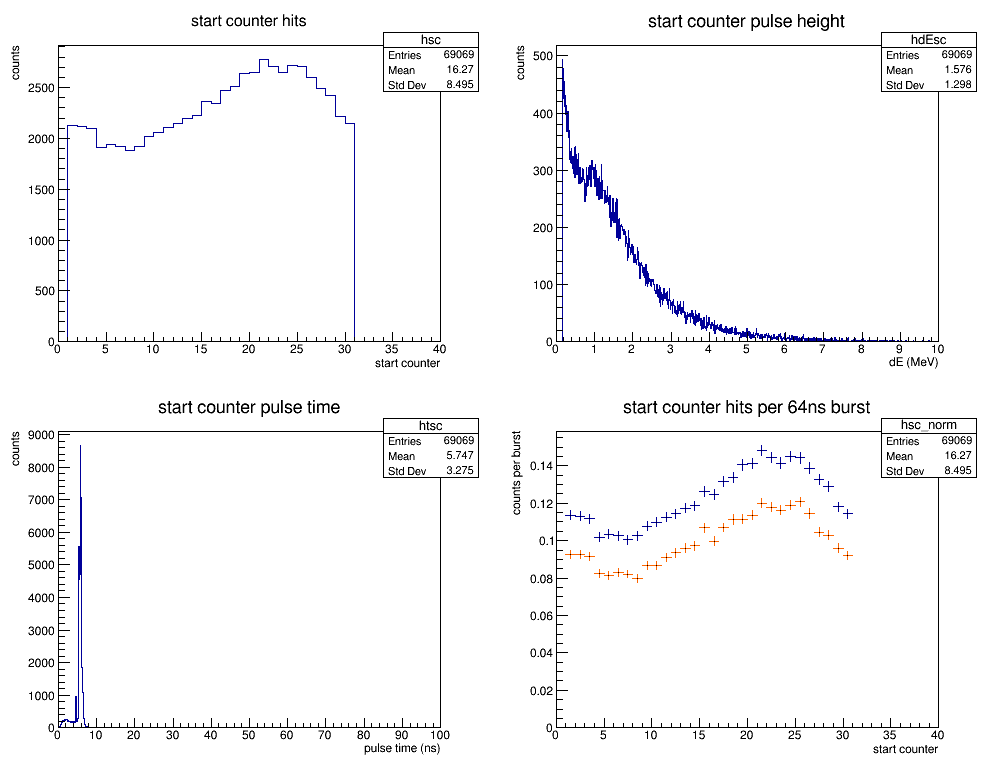

In [6]:
#hview.fill_histograms()
hview.draw([[['hsc', 'hsc_dEmin'], ['hdEsc', 'hdEsc_dEmin']],
            [['htsc', 'htsc_dEmin'], ]])

hsc_norm = {}
draw_option = ""
hview.current_canvas.cd(4)
for hname in ('hsc', 'hsc_dEmin'):
    horig = hview.get(hname)
    hname2 = hname + "_norm"
    hsc_norm[hname2] = horig.Clone(hname2)
    horig.Delete()
    hsc_norm[hname2].SetTitle("start counter hits per 64ns burst")
    hsc_norm[hname2].Scale(64e-9 / 1.2e-3)
    hsc_norm[hname2].GetYaxis().SetTitle("counts per burst")
    hsc_norm[hname2].Draw(draw_option)
    draw_option = "same"
hview.current_canvas.cd(0)
hview.current_canvas.Draw()

In [7]:
def tracker_hits_hinit():
    h = {}
    h['hcdc'] = ROOT.TH2D("hcdc", "cdc hits", 209, 1, 210, 28, 1, 29)
    h['hcdc'].GetXaxis().SetTitle("straw in ring")
    h['hcdc'].GetYaxis().SetTitle("cdc ring")
    h['hcdcrun'] = ROOT.TH1D("hcdcrun", "cdc hits per run", 1000, 120000, 130000)
    h['hcdcrun'].GetXaxis().SetTitle("run number")
    h['hcdcrun'].GetYaxis().SetTitle("counts")
    h['hdEcdc'] = ROOT.TH1D("hdEcdc", "cdc pulse height", 200, 0, 3e4)
    h['hdEcdc'].GetXaxis().SetTitle("pulse height (q)")
    h['hdEcdc'].GetYaxis().SetTitle("counts")
    h['htcdc'] = ROOT.TH1D("htcdc", "cdc straw hit time", 200, 0, 1000)
    h['htcdc'].GetXaxis().SetTitle("pulse time (ns)")
    h['htcdc'].GetYaxis().SetTitle("counts")
    h['hfdc'] = ROOT.TH2D("hfdc", "fdc hits", 99, 1, 100, 24, 1, 25)
    h['hfdc'].GetXaxis().SetTitle("anode wire")
    h['hfdc'].GetYaxis().SetTitle("fdc layer")
    h['hfdcrun'] = ROOT.TH1D("hfdcrun", "fdc hits per run", 91000, 120000, 130000)
    h['hfdcrun'].GetXaxis().SetTitle("run number")
    h['hfdcrun'].GetYaxis().SetTitle("counts")
    h['hdEfdc'] = ROOT.TH1D("hdEfdc", "fdc pulse height", 200, 0, 10)
    h['hdEfdc'].GetXaxis().SetTitle("dE (KeV)")
    h['hdEfdc'].GetYaxis().SetTitle("counts")
    h['htfdc'] = ROOT.TH1D("htfdc", "fdc anode wire hit time", 200, 0, 500)
    h['htfdc'].GetXaxis().SetTitle("pulse time (ns)")
    h['htfdc'].GetYaxis().SetTitle("counts")
    return h

def tracker_hits_hfill(record, histos):
    for pev in record.getPhysicsEvents():
        run = pev.runNo
    for hit in record.getCdcStrawTruthHits():
        histos['hcdc'].Fill(hit.getAttribute("straw"), hit.getAttribute("ring"))
        histos['hdEcdc'].Fill(hit.q)
        histos['htcdc'].Fill(hit.t)
        if hit.getAttribute("ring") == 1:
            histos['hcdcrun'].Fill(run)
    for hit in record.getFdcAnodeTruthHits():
        histos['hfdc'].Fill(hit.getAttribute("wire"), (hit.getAttribute("module") * 3 - 3) + hit.getAttribute("layer"))
        histos['hdEfdc'].Fill(hit.dE * 1e6)
        histos['htfdc'].Fill(hit.t)
        if hit.getAttribute("module") == 1 and hit.getAttribute("layer") == 1:
            histos['hfdcrun'].Fill(run)
    return histos

n = hview.declare_histograms("drift chambers", tracker_hits_hinit, tracker_hits_hfill)

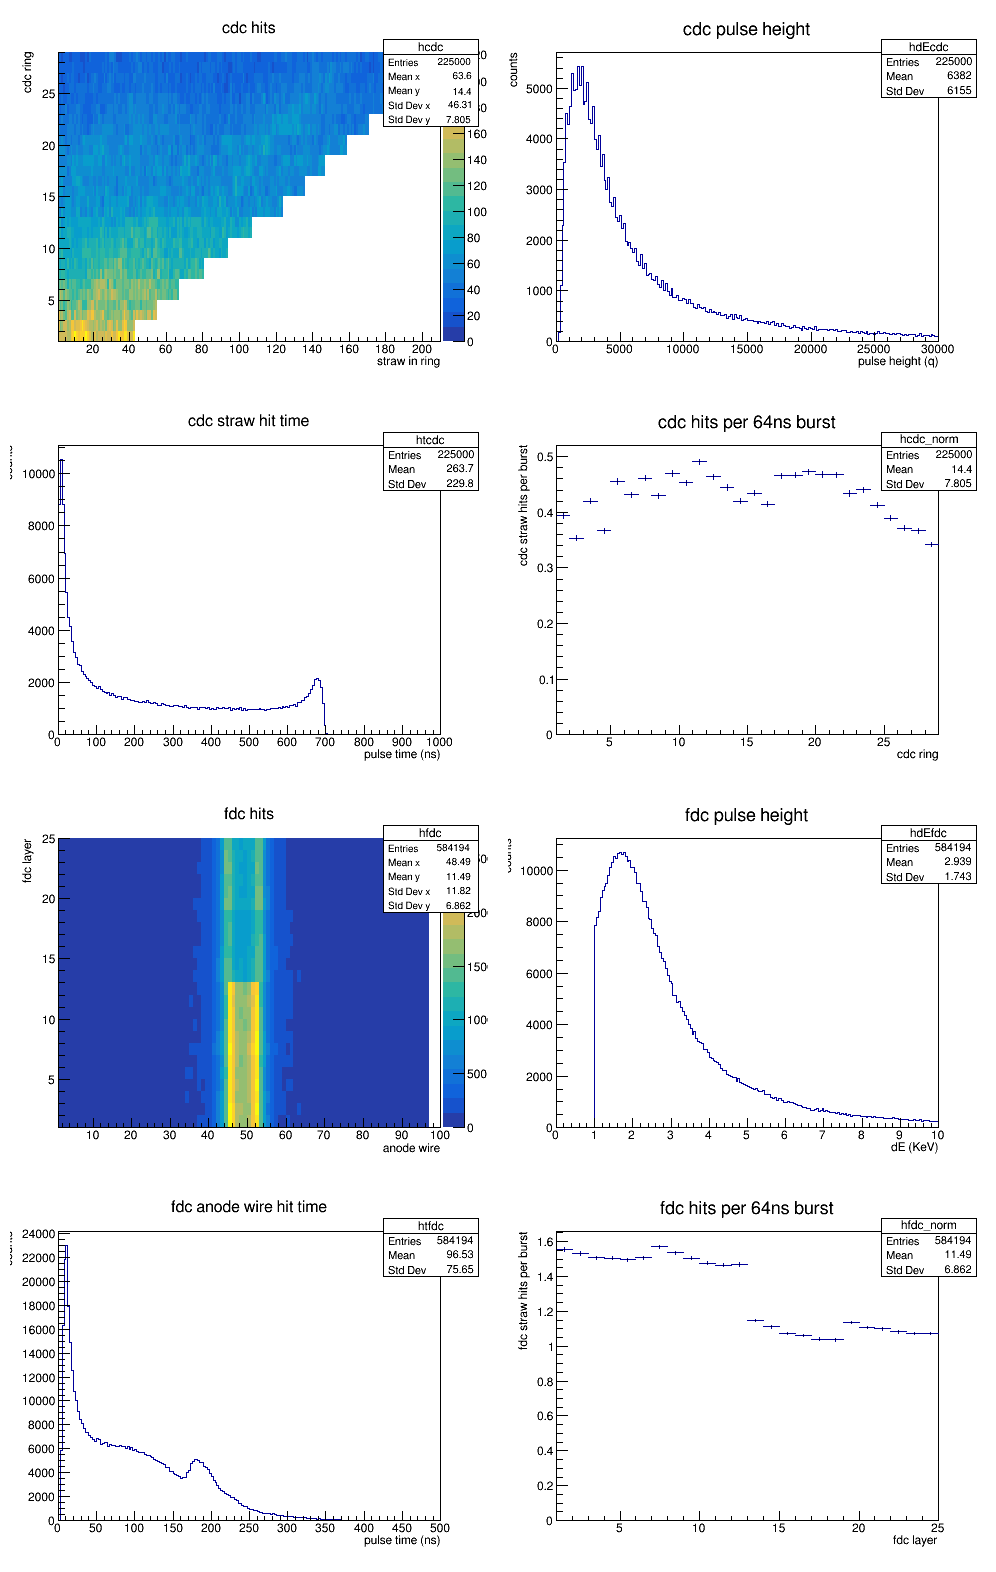

In [8]:
#hview.fill_histograms()
hview.draw([[['hcdc'], ['hdEcdc']],
            [['htcdc'], ],
            [['hfdc'], ['hdEfdc']],
            [['htfdc'], ]],
           [[['colz'], ['']],
            [[''], ],
            [['colz'], ['']],
            [[''], ]]
          )

hdc_norm = {}
canvas_pad = 0
for hname in ("hcdc", "hfdc"):
    hnorm = hname + "_norm"
    hdc_norm[hnorm] = hview.get(hname).ProjectionY(hnorm)
    hdc_norm[hnorm].SetTitle(hname[1:] + " hits per 64ns burst")
    hdc_norm[hnorm].Scale(64e-9 / 1.2e-3)
    hdc_norm[hnorm].GetYaxis().SetTitle(hname[1:] + " straw hits per burst")
    hdc_norm[hnorm].SetMinimum(0)
    canvas_pad += 4
    hview.current_canvas.cd(canvas_pad)
    hdc_norm[hnorm].Draw()
hview.current_canvas.cd(0)
hview.current_canvas.Draw()

In [9]:
def calorimeter_hits_hinit():
    h = {}
    h['hbcal'] = ROOT.TH2D("hbcal", "bcal hits", 97, -48, 49, 10, 1, 11)
    h['hbcal'].GetXaxis().SetTitle("bcal module (upstream < 0, downstream > 0)")
    h['hbcal'].GetYaxis().SetTitle("bcal layer")
    h['hbcalrun'] = ROOT.TH1D("hbcalrun", "bcal hits per run", 1000, 120000, 130000)
    h['hbcalrun'].GetXaxis().SetTitle("run number")
    h['hbcalrun'].GetYaxis().SetTitle("counts")
    h['hdEubcal'] = ROOT.TH1D("hdEubcal", "upstream bcal pulse height", 1000, 0, 1)
    h['hdEubcal'].GetXaxis().SetTitle("pulse height (GeV)")
    h['hdEubcal'].GetYaxis().SetTitle("counts")
    h['hdEdbcal'] = ROOT.TH1D("hdEdbcal", "downstream bcal pulse height", 1000, 0, 1)
    h['hdEdbcal'].GetXaxis().SetTitle("pulse height (GeV)")
    h['hdEdbcal'].GetYaxis().SetTitle("counts")
    h['htubcal'] = ROOT.TH1D("htubcal", "upstream bcal hit time", 200, 0, 1000)
    h['htubcal'].GetXaxis().SetTitle("pulse time (ns)")
    h['htubcal'].GetYaxis().SetTitle("counts")
    h['htdbcal'] = ROOT.TH1D("htdbcal", "downstream bcal hit time", 200, 0, 1000)
    h['htdbcal'].GetXaxis().SetTitle("pulse time (ns)")
    h['htdbcal'].GetYaxis().SetTitle("counts")
    h['hfcal'] = ROOT.TH2D("hfcal", "fcal hits", 60, 1, 61, 60, 1, 61)
    h['hfcal'].GetXaxis().SetTitle("column")
    h['hfcal'].GetYaxis().SetTitle("row")
    h['hfcalrun'] = ROOT.TH1D("hfcalrun", "fcal hits per run", 1000, 120000, 130000)
    h['hfcalrun'].GetXaxis().SetTitle("run number")
    h['hfcalrun'].GetYaxis().SetTitle("counts")
    h['hdEfcal'] = ROOT.TH1D("hdEfcal", "fcal pulse height", 2000, 0, 10)
    h['hdEfcal'].GetXaxis().SetTitle("dE (GeV)")
    h['hdEfcal'].GetYaxis().SetTitle("counts")
    h['htfcal'] = ROOT.TH1D("htfcal", "fcal block hit time", 200, 0, 500)
    h['htfcal'].GetXaxis().SetTitle("pulse time (ns)")
    h['htfcal'].GetYaxis().SetTitle("counts")
    hclones = {}
    for hname in h:
        hname2 = hname + "_dEmin"
        hclones[hname2] = h[hname].Clone(hname2)
        hclones[hname2].SetLineColor(ROOT.kOrange + 7)
    h.update(hclones)
    return h

def calorimeter_hits_hfill(record, histos, Emin_bcal=0.01, Emin_fcal=0.05):
    for pev in record.getPhysicsEvents():
        run = pev.runNo
    for hit in record.getBcalSiPMUpHits():
        histos['hbcal'].Fill(-hit.getAttribute("module"), hit.getAttribute("layer"))
        histos['hbcalrun'].Fill(run)
        histos['hdEubcal'].Fill(hit.E)
        histos['htubcal'].Fill(hit.t)
        if hit.E > Emin_bcal:
            histos['hbcal_dEmin'].Fill(-hit.getAttribute("module"), hit.getAttribute("layer"))
            histos['hbcalrun_dEmin'].Fill(run)
            histos['hdEubcal_dEmin'].Fill(hit.E)
            histos['htubcal_dEmin'].Fill(hit.t)
    for hit in record.getBcalSiPMDownHits():
        histos['hbcal'].Fill(+hit.getAttribute("module"), hit.getAttribute("layer"))
        histos['hdEdbcal'].Fill(hit.E)
        histos['htdbcal'].Fill(hit.t)
        if hit.E > Emin_bcal:
            histos['hbcal_dEmin'].Fill(+hit.getAttribute("module"), hit.getAttribute("layer"))
            histos['hdEdbcal_dEmin'].Fill(hit.E)
            histos['htdbcal_dEmin'].Fill(hit.t)
    for hit in record.getFcalTruthHits():
        histos['hfcal'].Fill(hit.getAttribute("column"), hit.getAttribute("row"))
        histos['hfcalrun'].Fill(run)
        histos['hdEfcal'].Fill(hit.E)
        histos['htfcal'].Fill(hit.t)
        if hit.E > Emin_fcal:
            histos['hfcal_dEmin'].Fill(hit.getAttribute("column"), hit.getAttribute("row"))
            histos['hfcalrun_dEmin'].Fill(run)
            histos['hdEfcal_dEmin'].Fill(hit.E)
            histos['htfcal_dEmin'].Fill(hit.t)
    return histos

n = hview.declare_histograms("calorimeters", calorimeter_hits_hinit, calorimeter_hits_hfill)

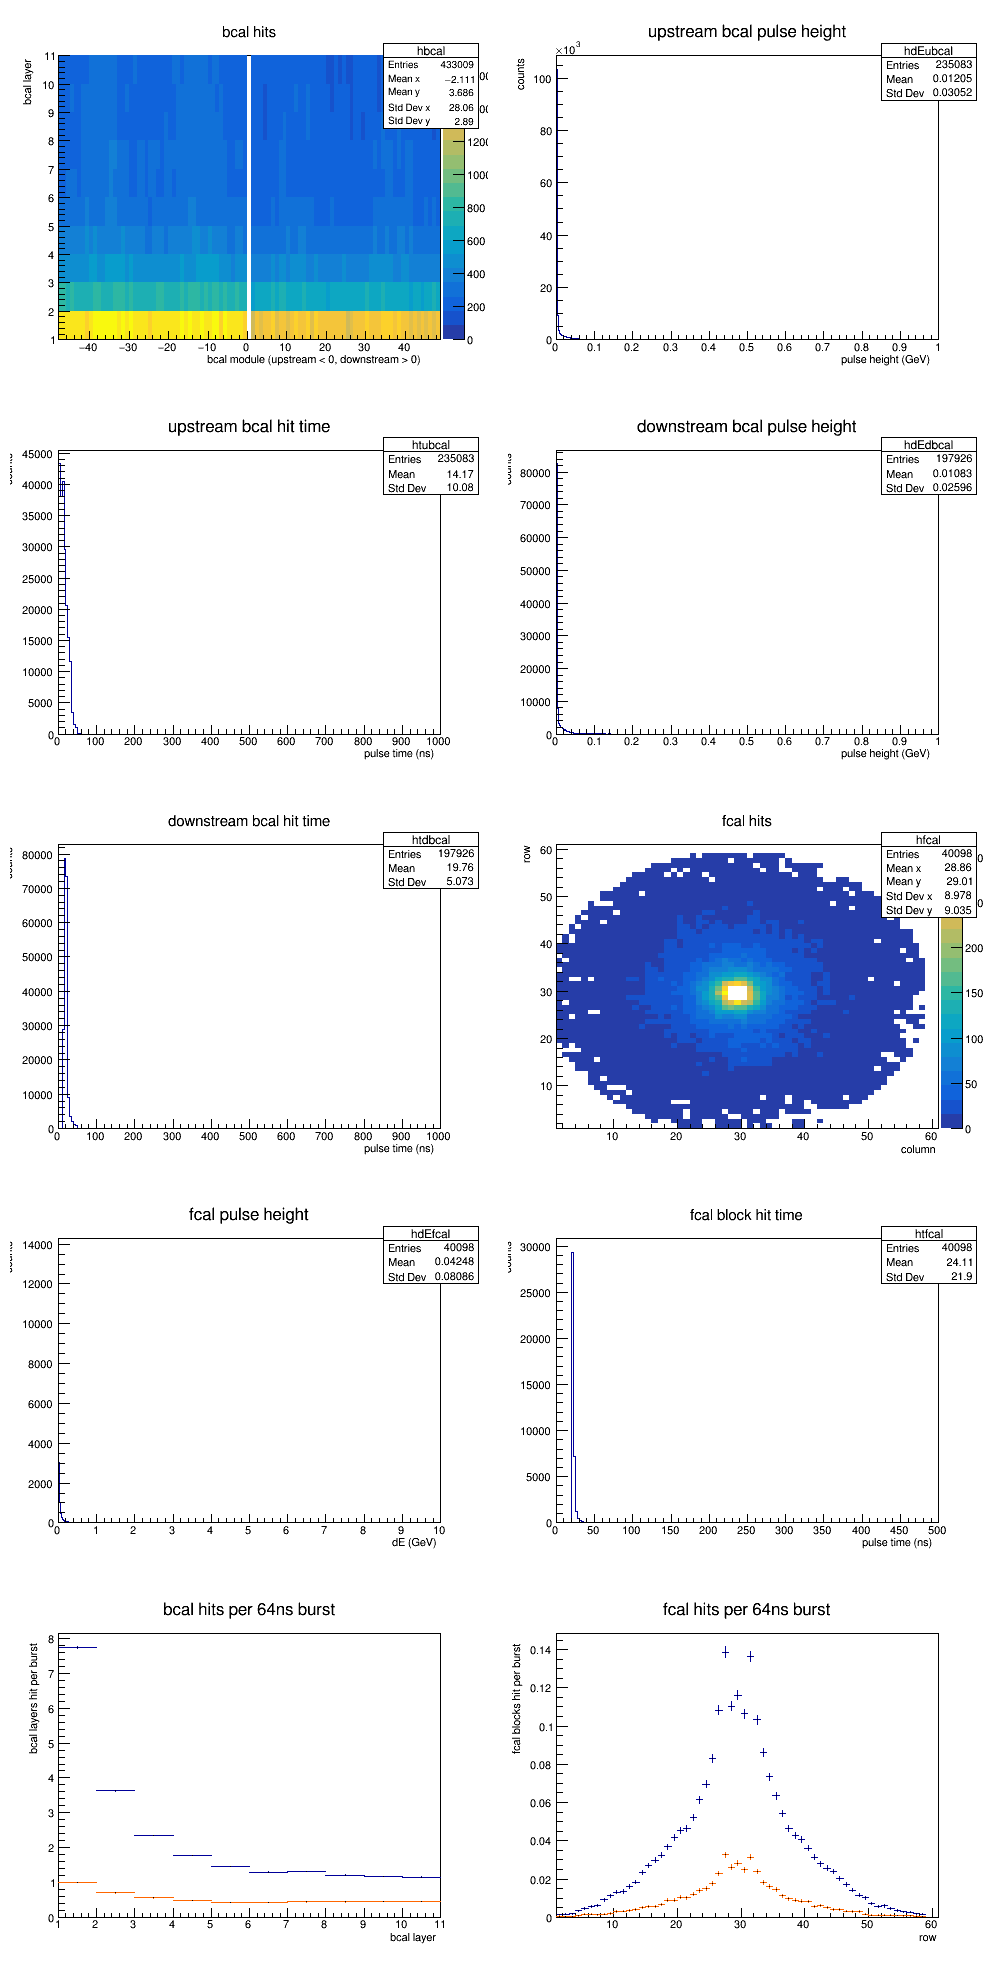

In [10]:
#hview.fill_histograms()
hview.draw([[['hbcal'], ['hdEubcal', 'hdEubcal_dEmin']],
            [['htubcal', 'htubcal_dEmin'], ['hdEdbcal', 'hdEdbcal_dEmin']],
            [['htdbcal', 'htdbcal_dEmin'], ['hfcal']],
            [['hdEfcal', 'hdEfcal_dEmin' ],['htfcal', 'htfcal_dEmin']], 
            [[], ]],
           [[['colz'], ['', '']],
            [['', ''], ['', '']],
            [['', ''], ['colz']],
            [['', ''], ['', '']],
            [[''], ]]
          )
hcal_norm = {}
draw_option = ""
canvas_panel = 9
for hname in ("hbcal", "hbcal_dEmin", "hfcal", "hfcal_dEmin"):
    horig = hview.get(hname)
    hnorm = hname + "_norm"
    hcal_norm[hnorm] = horig.ProjectionY(hnorm)
    hcal_norm[hnorm].SetTitle(hname[1:] + " hits per 64ns burst")
    hcal_norm[hnorm].Scale(64e-9 / 1.2e-3)
    hcal_norm[hnorm].SetMinimum(0)
    hcal_norm[hnorm].SetStats(0)
    if "bcal" in hname:
        hcal_norm[hnorm].GetYaxis().SetTitle("bcal layers hit per burst")
    else:
        hcal_norm[hnorm].GetYaxis().SetTitle("fcal blocks hit per burst")
    hview.current_canvas.cd(canvas_panel)
    hcal_norm[hnorm].Draw(draw_option)
    if draw_option == "":
        draw_option = "same"
    else:
        draw_option = ""
        canvas_panel += 1
hview.current_canvas.cd(0)
hview.current_canvas.Draw()

In [11]:
def tof_hits_hinit():
    h = {}
    h['htof'] = ROOT.TH1D("htof", "tof counter hits", 101, -50, 51)
    h['htof'].GetXaxis().SetTitle("tof counter (layer 1 < 0, layer 2 > 0)")
    h['htof'].GetYaxis().SetTitle("counts")
    h['htofrun'] = ROOT.TH1D("htofrun", "tof hits per run", 1000, 120000, 130000)
    h['htofrun'].GetXaxis().SetTitle("run number")
    h['htofrun'].GetYaxis().SetTitle("counts")
    h['hdEtof'] = ROOT.TH1D("hdEtof", "pulse height", 1000, 0, 10)
    h['hdEtof'].GetXaxis().SetTitle("dE (MeV)")
    h['hdEtof'].GetYaxis().SetTitle("counts")
    h['httof'] = ROOT.TH1D("httof", "tof counter pulse time", 1000, 0, 100)
    h['httof'].GetXaxis().SetTitle("pulse time (ns)")
    h['httof'].GetYaxis().SetTitle("counts")
    hclones = {}
    for hname in h:
        hname2 = hname + "_dEmin"
        hclones[hname2] = h[hname].Clone(hname2)
        hclones[hname2].SetLineColor(ROOT.kOrange + 7)
    h.update(hclones)
    return h

def tof_hits_hfill(record, histos, dEmin=1e-3):
    for pev in record.getPhysicsEvents():
        run = pev.runNo
    for hit in record.getFtofTruthHits():
        if hit.getAttribute("plane") == 1:
            histos['htof'].Fill(-hit.getAttribute("bar"))
            histos['htofrun'].Fill(run)
        else:
            histos['htof'].Fill(+hit.getAttribute("bar"))
        histos['hdEtof'].Fill(hit.dE * 1e3)
        histos['httof'].Fill(hit.t)
        if hit.dE > dEmin:
            if hit.getAttribute("plane") == 1:
                histos['htof_dEmin'].Fill(-hit.getAttribute("bar"))
                histos['htofrun_dEmin'].Fill(run)
            else:
                histos['htof_dEmin'].Fill(+hit.getAttribute("bar"))
            histos['hdEtof_dEmin'].Fill(hit.dE * 1e3)
            histos['httof_dEmin'].Fill(hit.t)
    return histos

n = hview.declare_histograms("time of flight", tof_hits_hinit, tof_hits_hfill)

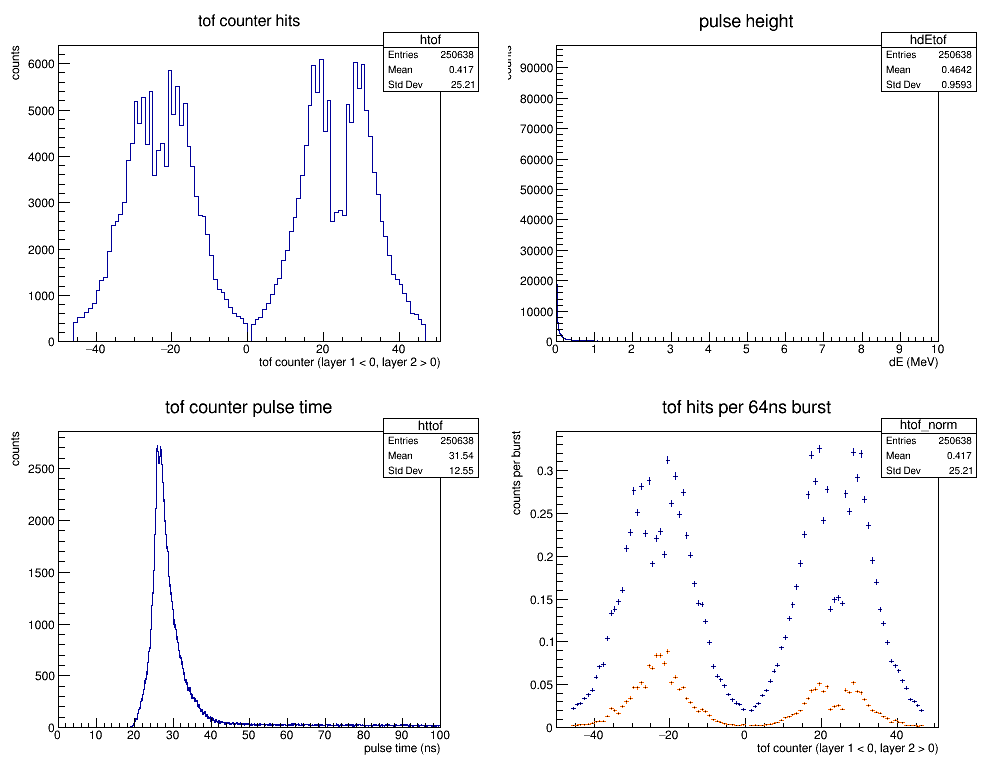

In [12]:
#hview.fill_histograms()
hview.draw([[['htof', 'htof_dEmin'], ['hdEtof', 'hdEtof_dEmin']],
            [['httof', 'httof_dEmin'], ]])

htof_norm = {}
draw_option = ""
hview.current_canvas.cd(4)
for hname in ('htof', 'htof_dEmin'):
    horig = hview.get(hname)
    hname2 = hname + "_norm"
    hsc_norm[hname2] = horig.Clone(hname2)
    horig.Delete()
    hsc_norm[hname2].SetTitle("tof hits per 64ns burst")
    hsc_norm[hname2].Scale(64e-9 / 1.2e-3)
    hsc_norm[hname2].GetYaxis().SetTitle("counts per burst")
    hsc_norm[hname2].Draw(draw_option)
    draw_option = "same"
hview.current_canvas.cd(0)
hview.current_canvas.Draw()

In [13]:
def start_hitz_hinit():
    h = {}
    h['hscz'] = ROOT.TH1D("hscz", "start counter hit z", 150, 0, 150)
    h['hscz'].GetXaxis().SetTitle("z (cm)")
    h['hscz'].GetYaxis().SetTitle("counts")
    h['hcdcz'] = ROOT.TH1D("hcdcz", "cdc straw hit z", 250, -50, 200)
    h['hcdcz'].GetXaxis().SetTitle("z (cm)")
    h['hcdcz'].GetYaxis().SetTitle("counts")
    hclones = {}
    for hname in h:
        hname2 = hname + "_dEmin"
        hclones[hname2] = h[hname].Clone(hname2)
        hclones[hname2].SetLineColor(ROOT.kOrange + 7)
    h.update(hclones)
    return h

def start_hitz_hfill(record, histos, dEmin=0.5e-3, qmin=0):
    for pt in record.getStcTruthPoints():
        histos['hscz'].Fill(pt.z)
        dEmax = 0
        for tid in pt.getTrackIDs():
            for hit in record.getStcTruthHits():
                if hit.itrack == tid.itrack and hit.dE > dEmax:
                    dEmax = hit.dE
        if dEmax > dEmin:
            histos['hscz_dEmin'].Fill(pt.z)
    for pt in record.getCdcTruthPoints():
        histos['hcdcz'].Fill(pt.z)
        qmax = 0
        for tid in pt.getTrackIDs():
            for hit in record.getCdcStrawTruthHits():
                if hit.itrack == tid.itrack and hit.q > qmax:
                    qmax = hit.q
        if qmax > qmin:
            histos['hcdcz_dEmin'].Fill(pt.z)
    return histos

n = hview.declare_histograms("inner detector z", start_hitz_hinit, start_hitz_hfill)

fill_histograms read a total of 10000 tree files, 5000000000.0 records


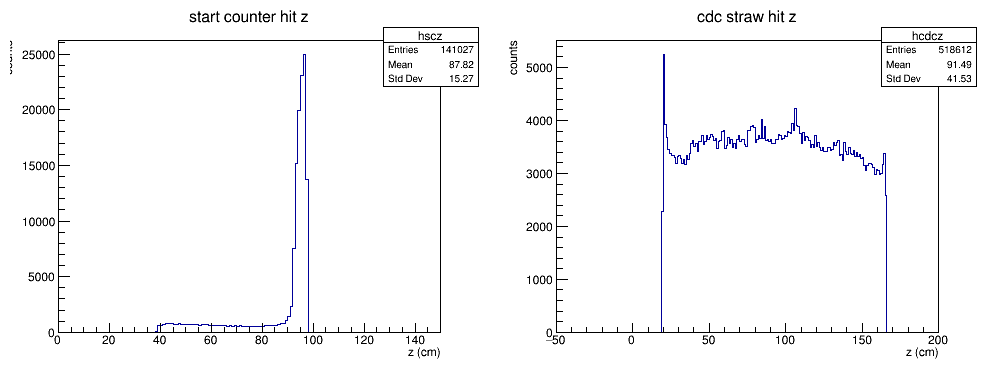

In [14]:
hview.fill_histograms()
n = hview.draw([[['hscz', 'hscz_dEmin'], ['hcdcz', 'hcdcz_dEmin']]])

In [15]:
hview.list_histograms(True)

hsc;1           start counter hits                                 69069   Fri Oct  4 12:28:49 2024
hscrun;1        start counter hits vs run                          69069   Fri Oct  4 12:28:49 2024
hdEsc;1         start counter pulse height                         69069   Fri Oct  4 12:28:49 2024
htsc;1          start counter pulse time                           69069   Fri Oct  4 12:28:49 2024
hsc_dEmin;1     start counter hits                                 56062   Fri Oct  4 12:28:49 2024
hscrun_dEmin;1  start counter hits vs run                          56062   Fri Oct  4 12:28:49 2024
hdEsc_dEmin;1   start counter pulse height                         56062   Fri Oct  4 12:28:49 2024
htsc_dEmin;1    start counter pulse time                           56062   Fri Oct  4 12:28:49 2024
hcdc;1          cdc hits                                          225000   Fri Oct  4 12:28:49 2024
hcdcrun;1       cdc hits per run                                    7376   Fri Oct  4 12:28:49 2024


49

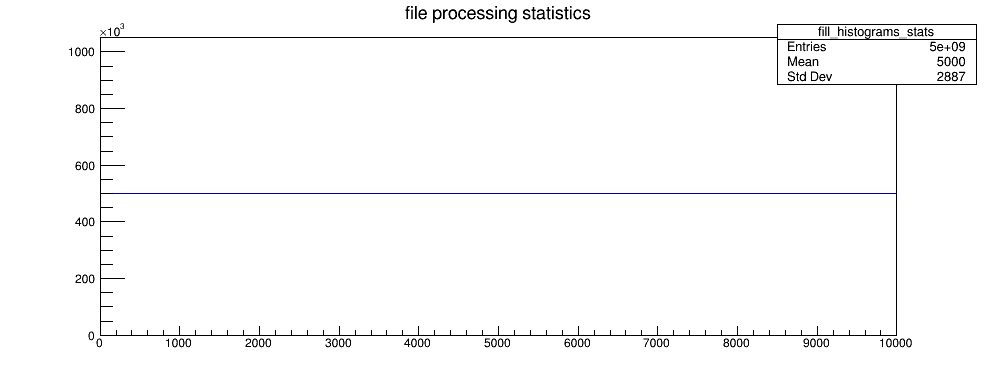

In [16]:
n = hview.draw('fill_histograms_stats', width=1000)